# Conversational Emergency AI with the Rasa stack
Update version (copy the notebook and run)

![alt text](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTaX3LNhGcAe1HnPZSuWS0oH6af0LJHXcH7If1sQgLCFAT1chNGFg)





*   Part 0: Setup workspace
*   Part 1: Teaching the chatbot to understand user inputs using Rasa NLU model
*   Part 2: Teaching the chatbot to handle multi-turn conversations using dialogue management model
*   Part 3: Chat with the bot


*   References:

    https://github.com/RasaHQ/rasa-workshop-pydata-berlin

    https://arxiv.org/abs/1712.05181


## Part 0: setup workspace

### Let's start with jupyter configuration

In [ ]:
%matplotlib inline

import logging, io, json, warnings
logging.basicConfig(level="INFO")
warnings.filterwarnings('ignore')

def pprint(o):
    # small helper to make dict dumps a bit prettier
    print(json.dumps(o, indent=2))

####Install Rasa NLU and Rasa Core. You can jump this step if you have already installed it on your PC.

In [ ]:
import sys
python = sys.executable

# In your environment run:
#!{python} -m pip install -U rasa_core==0.9.6 rasa_nlu[spacy]===0.12.3; #rasa_core==0.9.6 doesn't work anymore, so are used new updated versions
!{python} -m pip install -U rasa_core==0.11.12 rasa_nlu[spacy]===0.13.6;
!{python} -m pip install sklearn_crfsuite;

# as well as install a language model:
!{python} -m spacy download en_core_web_md
!{python} -m spacy link en_core_web_md en --force;

     |████████████████████████████████| 184kB 5.5MB/s 
     |████████████████████████████████| 153kB 17.6MB/s 
     |████████████████████████████████| 81kB 9.3MB/s 
     |████████████████████████████████| 460kB 17.3MB/s 
     |████████████████████████████████| 5.1MB 25.7MB/s 
     |████████████████████████████████| 71kB 10.6MB/s 
     |████████████████████████████████| 61kB 9.9MB/s 
     |████████████████████████████████| 112kB 54.6MB/s 
     |████████████████████████████████| 71kB 10.1MB/s 
     |████████████████████████████████| 51kB 8.8MB/s 
     |████████████████████████████████| 58.4MB 47kB/s 
     |████████████████████████████████| 665kB 51.5MB/s 
     |████████████████████████████████| 307kB 52.4MB/s 
     |████████████████████████████████| 4.9MB 48.3MB/s 
     |████████████████████████████████| 133kB 57.9MB/s 
     |████████████████████████████████| 133kB 62.8MB/s 
     |████████████████████████████████| 12.8MB 241kB/s 
     |████████████████████████████████| 122kB 30.0MB/s 
  

In [ ]:
import rasa_nlu
import rasa_core
import spacy

print("rasa_nlu: {} rasa_core: {}".format(rasa_nlu.__version__, rasa_core.__version__))
print("Loading spaCy language model...")
print(spacy.load("en")("Hello world!"))

rasa_nlu: 0.13.6 rasa_core: 0.11.12
Loading spaCy language model...
Hello world!


####Install some graph packages. You can jump this step if you have already installed it on your PC.

In [ ]:
#new version doesn't work with Rasa
#!apt-get -qq install -y graphviz libgraphviz-dev pkg-config;
#!breq install graphviz
#!{python} -m pip install pygraphviz;

## Part 1: Natural Language Understanding

Here some examples of the conversation with sentences from the user and exploited to build Rasa NLU model.  

**Conversation_1:**   
U: Hello  

B: Hello, how can I help you?  

U: It's urgent I need an ambulance, please  

B: The number to call is: 112

U: Yes, thanks

B: You're welcome
    
**Conversation_2:**  
U: Hey  

B: Hello, how can I help you?   

U: Crime is happening we need to call the police, please

B: The number to call is: 112

U: Thank you

B: You're welcome
  
**Conversation_3:**    
U: Heya  

B: Hello, how can I help you?   

U: Thieves are entered in my home I need to call my insurance Company, please

B: The number to call is: 800-185-001

U: Great

B: You're welcome  
 


### Creating the training data for language understanding model

In this step is originated a train set grouping user inputs into intents and highlighting key word by entities with its synonyms (entity values).  

In [ ]:
nlu_md = """
## intent:greet
- hey
- hello there
- hi
- hello
- good morning
- good evening
- hey there
- let's go
- hey dude
- goodmorning
- goodevening
- good afternoon

## intent:affirm
- great
- OK
- okay
- thank you
- thanks
- yes, thanks
- cheers
- thanks a lot
- thank you very much

## intent: emergency_fire
- It's urgent I need to call the [fire department](Fire), please
- We need the [fire brigade](Fire), please
- I have to call the [firefighters](Fire), please
- A fire has spread in the room, I have to call the [firefighters](Fire), it's urgent!!!
- The fire alarm has been triggered, we need to contact the [fire department](Fire), we need an help!!!
- I have to call the [fire chief](Fire), please
- I need to alert the [firefighters](Fire), fire doors are open
- I need to call [firefighters](Fire), fire has spread into the building, is not a fire drill
- I have to call the [fire engine](Fire), please
- Fire is spread into the rooms, we need a fire escape to exit from the building, I need to reach the [fire department](Fire)!!!
- I have to call [firefighters](Fire) and use fire exit!!!
- We need a fire extinguisher to stop the fire, I need to call the [fire department](Fire), please
- Pay attention to the fire hazard, I have to call the [fire department](Fire)!!!
- I need help of the [fire brigade](Fire) for the use of fire hydrant
- The house is burned, I have to phone the [fire department](Fire)
- A fire lighter has exploded and the room has burned, I need help from the [fire department](Fire)
- I have to call the next [fire protection](Fire) district, please
- I need help of the [fire authority](Fire), please
- I need to call the [fire and rescue service](Fire), please
- Let's call the [fire station](Fire), please
- Let's call volunteer [firefighters](Fire), we need an urgent help!!!
- I have to call paid on call [firefighters](Fire), please
- Let's call the [fire protection](Fire), please
- Let's alert the [fire investigators](Fire), please
- I need to call the [firefighters](Fire)
- I need to contact the [firefighters](Fire)
- Please provide me the number of [fire brigade](Fire)
- I have an emergency situation, please give me the [firefighters](Fire) number
- Let's contact the nearest [firefighters station](Fire) and ask for help
- We need help, I have fire in my house, I need to contact the [fire brigade](Fire)
- My house is burning,  please I need to contact the [firefighters](Fire)
- Please I need to contact the [fire and rescue service](Fire)
- Neighbour's house is burning, I need to contact [fire department](Fire)
- I have to call the [fireman](Fire)
- Please let's contact the [firefighters department](Fire)
- We need the service of the [firefighters](Fire) here
- The fire alarm is not working let's contact the [firefighters](Fire)
- Please I have to call the [fire patrol](Fire) immediately
- I need to phone the [firefighters](Fire)
- I have to phone the [firefighters station](Fire)
- We cannot stop the fire, we need to call the [fire brigade](Fire)
- Fire is everywhere, I have to call the [fire department](Fire)
- Fire is unstoppable, I have to call the close [fire station](Fire)
- Fire is developing very fast, I have to call [firemen](Fire)
- We have emergency at house, it burning, I have to contact the [fire protection](Fire)


## intent: emergency_police
- I have to call the [police](Police), please
- I need to call the [boys in blue](Police), please
- I have to phone the [constabulary](Police), please
- I have to contact the [fuzz](Police), please
- I need to reach the [law enforcement](Police), please
- I need to call the [police force](Police) there are shots in the street
- I have to contact the [law](Police), please
- I have to reach the [Old Bill](Police), please
- I need an urgent help of the [police officer](Police), please
- I have to contact the [FBI](Police), please
- Urgent help of the [policemen](Police) is required, please
- I need a [policewoman](Police), please
- I have to call the [policeman](Police), please
- Help from the [cops](Police) is required, please
- I have to call the [officer](Police), please
- I have to phone the [man](Police), please
- Urgent help from the [authority](Police) is required, please
- I have to call the [guard](Police), please
- I have to call the [patrolman](Police), please
- I need an urgent help from the [gendarmerie](Police), please
- I have to call the [crime prevention](Police), please
- Help from the [police service](Police) is required, please
- Show me the [police department](Police) number, please
- Give me the [protective services](Police) number, please
- Show me [civil guard](Police) number, please
- I have to call the [civic guard](Police), please
- I need an urgent help from [troopers](Police), please
- I have to call [sheriff](Police), please
- I need an urgent help from [rangers](Police), please
- I need to phone [military police](Police), please
- I have to call [police constable](Police), please
- I need to contact the [police station](Police), please
- Show me the [riot police](Police) number, please
- I have to call the [secret police](Police), please
- I need to phone the [district police](Police), please
- I have to call the [police authority](Police), please
- I need to phone the [police captain](Police), please
- I need an urgent help of the [police car](Police), please
- I have to call the [police chief](Police), please
- I have to contact the [police commissioner](Police), please
- I need to contact the [police detective](Police), please
- I need to call the [police headquarter](Police), please
- I have to call the [police inspector](Police), please
- I have to contact the [police liutenant](Police), please
- I need an urgent help of the [police officer](Police), please
- I have to call a [police raid](Police), please
- Show me the [police sergeant](Police) number, please
- I need to call the [police squad](Police), please
- I have to call the [police van](Police), please
- I need an urgent help of the [police wagon](Police), please
- I have to contact the [state police](Police), please
- I have to reach the [public services](Police), please
- I have to contact with the [uniforms](Police), please
- I need an help of the [police department](Police), please
- Urgent help of the [criminal justice](Police) is required, please
- I have to call the [highway patrol](Police), please
- I need to call the [law enforcement](Police), please
- I need to contact the [law enforcement](Police), please
- I need to phone the [vigilante](Police), please
- I have to call the [public security](Police), please
- I have to phone the [private police](Police), please
- I need to call to [police](Police)
- I need to contact the [police](Police)
- Do you have [police number](Police)? I need to call them
- I have emergency situation, urgent help from the [police](Police) is required
- What is the closest [police station](Police) number?
- I have to call the nearest [police station](Police) and ask for help
- We need help from [officers](Police)
- Crime is happening, I have to contact the [police](Police)
- Please urgent help of the [cops](Police) is required
- Please help of the [FBI](Police) is required
- Please help from the [officer](Police) is required
- What is the [guard](Police) number?
- What is the [sheriff](Police) number?
- I have to call the [sheriff](Police)
- What is the [police department](Police) number?
- Please I have to contact the [police department](Police)
- We need the service of the [police](Police) here
- The watch is missing please I need an help of the [police](Police) here
- What is the [cops](Police) number?
- Please I need to call the [cops](Police) immediately
- Please I have to contact the [highway patrol](Police)
- I have to alert the men in [blue uniforms](Police)
- Please I have to alert the [police](Police), theft has happened
- Please I have to alert the [police station](Police)
- Please I have to alert the [guard](Police)
- Please the [police](Police) is required
- I need to phone the [police](Police) I need an urgent help
- I have to phone the [police station](Police)
- There has been an accident in the highway with injures, we need to call the [police](Police)


## intent: emergency_insurance_number
- Give me the [insurance number](Insurance), please
- I have to call my [insurance Company](Insurance), please
- Give me the [health insurance number](Insurance), please
- Give me the [insurance Company number](Insurance), please
- Give me the [life insurance number](Insurance), please
- Give me the [medical insurance number](Insurance), please
- Give me the [insurance agent number](Insurance), please
- Give me the [car insurance number](Insurance), please
- Give me the [social insurance number](Insurance), please
- I have to call the [insurance toll-free number](Insurance), please
- My leg is broken I need to call for the [allowance](Insurance), please
- My home is burned down I have to call for the [coverage](Insurance), please
- Windows of the car are broken I have to contact for the [guarantee](Insurance), please
- I need to call for the home [protection](Insurance)
- Thieves are entered in my home, I need to call my [insurance Company](Insurance)
- I need to call the [assurance Company](Insurance), please. It's really urgent!!!
- I have to call the [insurance Company](Insurance), please. I need an help!!! 
- I need to ask about surgery done, show me the [medical insurance number](Insurance), please
- I've had an accident by car, show me my [insurance number](Insurance), please
- I have a water leak at home, I urgently need the [insurance number](Insurance)
- I crashed to light pole I need the [insurance number](Insurance), please
- I want to pay the insurance premium, give me the [car insurance number](Insurance), please
- I want clarification on my policy, I need the [insurance agent number](Insurance), please
- I want to pay an additional premium on my policy, show me the [life insurance number](Insurance), please
- I want to have a summary of my pension scheme situation, show me the [social insurance number](Insurance), please 
- I am waiting since too much days payment from my policy, I want to contact my [insurance Company](Insurance), please
- I've changed my adress, I have to call my [insurance Company](Insurance) to update it, please
- I want to ask for clarification of my house policy, I have to call my [insurance Company](Insurance), please
- I want to ask a surrender on my life policy, give me the [life insurance number](Insurance), please
- My car was stolen, I have to call my [insurance Company](Insurance), please

## intent: emergency_road_help
- I have to call the [tow truck](Road_help), please
- I need to call the [wrecker](Road_help), please
- I have to call the [tow car](Road_help), please
- I need to contact the [tow truck driver](Road_help), please
- I need to phone the [breakdown van](Road_help), please
- I have to call the [breakdown lorry](Road_help), please
- I need an urgent help of the [tow](Road_help), please
- I have to phone the [trailer](Road_help), please
- I need to contact the [breakdown truck](Road_help), please
- I have to call the [recovery truck](Road_help), please
- I need to call the [breakdown services](Road_help)
- I have to contact the [breakdown services](Road_help)
- Please provide me the number of [truck services](Road_help)
- Do you have the number of [breakdown services](Road_help)? I need to call them
- I have an emergency situation, I have to call the [breakdown services](Road_help), please
- I have to call the nearest [breakdown services station](Road_help) for asking help
- We need help, I have a car breakdown on the road, a [recovery truck](Road_help), please
- My car is not working, I need to call the [breakdown truck](Road_help)
- My car has stopped in the middle of the road, please contact the [breakdown services](Road_help)
- I need to contact the [breakdown lorry](Road_help), please
- I have to ask a [breakdown van](Road_help), please
- I need to phone the [breakdown services](Road_help), please
- Is there any [tow truck](Road_help) near from us?
- My friend has problems with its car on the road, I need to call a [tow truck](Road_help)
- I have to contact the [breakdown services department](Road_help), please
- We need the service of the [tow truck](Road_help) here!!!
- The car has broken down I need a [recovery truck](Road_help), please
- I have to call the [tow truck company](Road_help)
- I need to find the nearest [tow truck](Road_help) from here, please
- I have to contact the [breakdown services](Road_help), please
- I have to call a [tow truck driver](Road_help) to help me with the broken car on the road
- I need help from the closest [breakdown services](Road_help), please
- I need to request [tow truck](Road_help), please
- I need to phone the [breakdown services](Road_help), please 
- The car has stopped, we need a [breakdown lorry](Road_help), please
- I cannot drive anymore I need to call a [breakdown van](Road_help), please
- The car is wrack, I have to call a [tow](Road_help), please
- The car needs to be taken from the road, I have to phone a [recovery truck](Road_help), please
- The car has smoke, I need a [recovery truck](Road_help), please
- The car needs to be brought to the next garage, I have to call a [tow truck driver](Road_help), please

## intent: emergency_air_rescue
- I have to call the [rega](Air_rescue), please
- I need to contact the [rescue by helicopter](Air_rescue), please
- I have to call the [air-ambulance](Air_rescue) to reach me here in mountain, please
- I have to phone the [emergency response unit](Air_rescue), please
- I need to call [flying doctors](Air_rescue), please
- I need to contact the [air-emergency](Air_rescue), please
- Let's call [air-help](Air_rescue), please
- I need to ask for [helicopter](Air_rescue), please
- I need to contact the [rescue team by helicopter](Air_rescue), please
- Provide me the number of [helicopter paramedics](Air_rescue) to reach me in mountain, please
- I need to contact the next [helicopter station](Air_rescue), please
- Give me the contact of the closest [air-paramedics](Air_rescue) here in mountain, please
- An [hospital helicopter](Air_rescue) should hurry here on the glacier
- I have to contact the [air-ambulance department](Air_rescue), please
- I need to contact the [red cross helicopter](Air_rescue) to reach me on the glacier, please
- I have to call the [emergency helicopter](Air_rescue) in mountain, please
- I need to find the next [emergency helicopter](Air_rescue), please
- I have to contact the [emergency helicopter](Air_rescue) to help me on mountain, please
- I have to alarm the [helicopter](Air_rescue) to reach me on mountain, please
- Injured in mountain, high-priority by [air-ambulance](Air_rescue) is required
- We need help in mountain, people are wounded, I have to call the [helicopter](Air_rescue), please 
- I'm wounded, I have to call the [helicopter](Air_rescue), please
- I'm in mountain and my leg is broken, I need the [helicopter](Air_rescue), please
- I'm hurt in mountain I have to contact [air-ambulance](Air_rescue), please
- Heart attack in mountain, mandatory the [air-ambulance](Air_rescue), please
- My family is in danger after landslide, some are wounded, I have urgent need to call the [rega](Air_rescue), please
- Necessary help, people are wounded after a landslide, I have to call the [helicopter](Air_rescue), please
- People are seriously injured, I have to call the [helicopter](Air_rescue), please
- Necessity to save people life on mountain, they are hurt and in danger, [air-help](Air_rescue) needed, please
- I have to call [air-ambulance](Air_rescue) to help injured people in mountain, please
- The accident occured on the mountain path, many people are injured, I have to call [air-ambulance](Air_rescue)
- The bleeding cannot stop, urgent help needed, I have to call the [air-ambulance](Air_rescue), please
- I need to be brought to the next hospital in a hurry, I need to phone the [helicopter](Air_rescue)
- My friend needs urgent medical attention, I have to call [flying doctors](Air_rescue), please
- We've had an accident on mountain path, people's health is critical, we need the [emergency response unit](Air_rescue)
- Nature catastrophe has injured many people, [air-help](Air_rescue) is required, please
- Please I have to call quickly [helicopter](Air_rescue), people are trapped in the mountain
- There has been a landslide, people seem to have trauma, I have to call [helicopter](Air_rescue)
- Heartquake has happened in mountain, we need an urgent [helicopter](Air_rescue), please

## intent: emergency_ambulance
- I need to call the [ambulance](Ambulance), please
- It's urgent we need to call the [hospital wagon](Ambulance), please
- Help me I need to call the [mobile hospital](Ambulance), please
- I need assistance, call the [red cross truck](Ambulance), please
- Give me the [sick transport](Ambulance) number, please
- Call [paramedics](Ambulance), please
- [injuries](Ambulance), I need a number for help, please
- I need to call the [ambulance](Ambulance)
- I need to call [paramedics](Ambulance)
- I need to contact [paramedics](Ambulance)
- Please provide me the number of [paramedics](Ambulance)
- Do you have the number of the [hospital wagon](Ambulance)? I need to call them
- I have an emergency situation, please give me [paramedics](Ambulance) number
- Where is the next [paramedics station](Ambulance)?
- Call the nearest [paramedics station](Ambulance) for help
- Please provide me [paramedics](Ambulance) number
- [Hospital wagon](Ambulance) should hurry
- Where is the next [paramedics department](Ambulance)?
- Please contact [paramedics department](Ambulance)
- Find the [emergency truck](Ambulance)
- Please alarm [paramedics](Ambulance)
- Necessary help, people are wounded, we need to call the [ambulance](Ambulance)
- I'm wounded urgent [ambulance](Ambulance) is needed
- My hand is broken, [ambulance](Ambulance) should hurry
- My leg is broken, [paramedics](Ambulance) are required
- I'm hurt please I need to contact [paramedics](Ambulance)
- Heart attack, [red cross truck](Ambulance) should hurry
- He's been accidentally cut and he's bleeding, urgent help required, [paramedics](Ambulance) needed
- My family is in danger, some are wounded, [red cross truck](Ambulance) is needed 
- People are wounded, get me in touch with [hospital wagon](Ambulance)
- We've had an accident, people's health is critical, [paramedics](Ambulance) are required
- Nature catastrophe has injured many people, [red cross truck](Ambulance) is required
- Necessity to save people life, they are hurt and in danger, [ambulance](Ambulance) needed
- I need to call [sick transport](Ambulance) to help injured people
- I have a critical situation, I need to call [ambulance](Ambulance)
- I don't feel my legs, I need urgency help, give me [mobile hospital](Ambulance) number
- People are seriously injured, high-priority is required, we need to reach the [ambulance](Ambulance)
- Please give me quickly [paramedics](Ambulance) number
- There has been an accident people seem to have trauma, we need to call [sick transport](Ambulance)
"""

%store nlu_md > nlu.md

Writing 'nlu_md' (str) to file 'nlu.md'.


### Defining the NLU model

With the training dataset is possible to build the NLU model by a pipeline which defines how structured data is extracted from unstructured user inputs. 

In [ ]:
config = """
language: "en"

pipeline:
- name: "nlp_spacy"                   # loads the spacy language model
- name: "tokenizer_spacy"             # splits the sentence into tokens
- name: "ner_crf"                     # uses the pretrained spacy NER model
- name: "intent_featurizer_spacy"     # transform the sentence into a vector representation
- name: "intent_classifier_sklearn"   # uses the vector representation to classify using SVM
- name: "ner_synonyms"                # trains the synonyms
""" 

%store config > config.yml

Writing 'config' (str) to file 'config.yml'.


### Training the Rasa NLU Model

Let's start training the dataset with user inputs.

In [ ]:
from rasa_nlu.training_data import load_data
from rasa_nlu.config import RasaNLUModelConfig
from rasa_nlu.model import Trainer
from rasa_nlu import config

# loading the nlu training samples
training_data = load_data("nlu.md")

# trainer to educate our pipeline
trainer = Trainer(config.load("config.yml"))

# train the model!
interpreter = trainer.train(training_data)

# store it for future use
model_directory = trainer.persist("./models/nlu", fixed_model_name="current")

INFO:rasa_nlu.training_data.loading:Training data format of nlu.md is md
INFO:rasa_nlu.training_data.training_data:Training data stats: 
	- intent examples: 304 (8 distinct intents)
	- Found intents: 'emergency_air_rescue', 'emergency_police', 'emergency_ambulance', 'emergency_fire', 'emergency_road_help', 'greet', 'emergency_insurance_number', 'affirm'
	- entity examples: 283 (6 distinct entities)
	- found entities: 'Ambulance', 'Road_help', 'Police', 'Fire', 'Air_rescue', 'Insurance'

INFO:rasa_nlu.utils.spacy_utils:Trying to load spacy model with name 'en'
INFO:rasa_nlu.components:Added 'nlp_spacy' to component cache. Key 'nlp_spacy-en'.
INFO:rasa_nlu.model:Starting to train component nlp_spacy
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Starting to train component tokenizer_spacy
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Starting to train component ner_crf
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Starti

Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.8s finished
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Starting to train component ner_synonyms
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Successfully saved model into '/content/models/nlu/default/current'


### Using & evaluating the NLU model

Have a look on how the model is performing on a sentence:

In [ ]:
pprint(interpreter.parse("Heartquake has happened, urgent help is necessary"))

{
  "intent": {
    "name": "emergency_air_rescue",
    "confidence": 0.34655450830394396
  },
  "entities": [],
  "intent_ranking": [
    {
      "name": "emergency_air_rescue",
      "confidence": 0.34655450830394396
    },
    {
      "name": "emergency_police",
      "confidence": 0.29056515037322034
    },
    {
      "name": "emergency_ambulance",
      "confidence": 0.13496348754111795
    },
    {
      "name": "emergency_road_help",
      "confidence": 0.07884641216902621
    },
    {
      "name": "emergency_insurance_number",
      "confidence": 0.06858546065974933
    },
    {
      "name": "emergency_fire",
      "confidence": 0.0415755234739192
    },
    {
      "name": "greet",
      "confidence": 0.026226964725542243
    },
    {
      "name": "affirm",
      "confidence": 0.012682492753480637
    }
  ],
  "text": "Heartquake has happened, urgent help is necessary"
}


Evaluation of a standalone model using all the dataset without a split train-test for semplicity. Upgraded version afford the split train-test option.

INFO:rasa_nlu.components:Added 'nlp_spacy' to component cache. Key 'nlp_spacy-en'.
INFO:rasa_nlu.training_data.loading:Training data format of nlu.md is md
INFO:rasa_nlu.training_data.training_data:Training data stats: 
	- intent examples: 304 (8 distinct intents)
	- Found intents: 'emergency_air_rescue', 'emergency_police', 'emergency_ambulance', 'emergency_fire', 'emergency_road_help', 'greet', 'emergency_insurance_number', 'affirm'
	- entity examples: 283 (6 distinct entities)
	- found entities: 'Ambulance', 'Road_help', 'Police', 'Fire', 'Air_rescue', 'Insurance'

INFO:rasa_nlu.evaluate:Intent evaluation results:
INFO:rasa_nlu.evaluate:Intent Evaluation: Only considering those 304 examples that have a defined intent out of 304 examples
INFO:rasa_nlu.evaluate:F1-Score:  0.9967011330704313
INFO:rasa_nlu.evaluate:Precision: 0.9967466743782534
INFO:rasa_nlu.evaluate:Accuracy:  0.9967105263157895
INFO:rasa_nlu.evaluate:Classification report: 
                            precision    rec

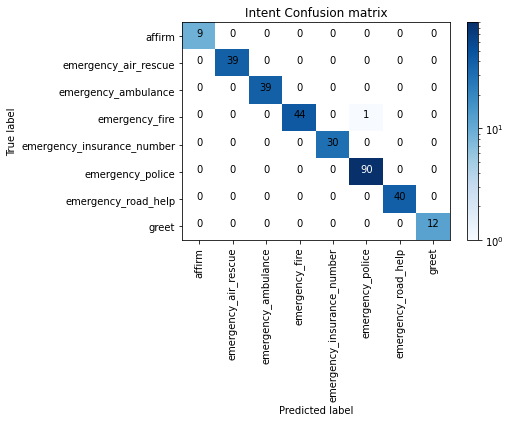

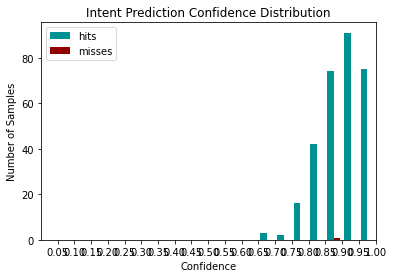

INFO:rasa_nlu.evaluate:Entity evaluation results:
INFO:rasa_nlu.evaluate:Evaluation for entity extractor: ner_crf 
INFO:rasa_nlu.evaluate:F1-Score:  1.0
INFO:rasa_nlu.evaluate:Precision: 1.0
INFO:rasa_nlu.evaluate:Accuracy:  1.0
INFO:rasa_nlu.evaluate:Classification report: 
             precision    recall  f1-score   support

 Air_rescue       1.00      1.00      1.00        85
  Ambulance       1.00      1.00      1.00        61
       Fire       1.00      1.00      1.00        78
  Insurance       1.00      1.00      1.00        72
     Police       1.00      1.00      1.00       141
  Road_help       1.00      1.00      1.00        82
  no_entity       1.00      1.00      1.00      2592

avg / total       1.00      1.00      1.00      3111



In [ ]:
from rasa_nlu.evaluate import run_evaluation

run_evaluation("nlu.md", model_directory)


# Part 2: Handling the dialogue

In this part at the chatbot is taught how to make responses by training a dialogue management model with Rasa Core.

### Writing Stories

The dataset used for dialogue management models are represented by 'stories': actual conversations. User inputs expressed by intents, entities and value entities, start with '*'. Chatbot responses expressed as actions, start with '-'. 

In [ ]:
stories_md = """
## path 1               
* greet
  - utter_greet             
* emergency_ambulance{"Ambulance":"ambulance"}  
  - utter_action_help_ambulance
* affirm  
  - utter_affirm

## path 2               
* greet
  - utter_greet             
* emergency_ambulance{"Ambulance":"mobile hospital"}  
  - utter_action_help_ambulance  
* affirm
  - utter_affirm

## path 3               
* greet
  - utter_greet             
* emergency_ambulance{"Ambulance":"red cross truck"}  
  - utter_action_help_ambulance  
* affirm
  - utter_affirm  
  
## path 4               
* greet
  - utter_greet             
* emergency_ambulance{"Ambulance":"hospital wagon"}  
  - utter_action_help_ambulance  
* affirm
  - utter_affirm  

## path 5               
* greet
  - utter_greet             
* emergency_ambulance{"Ambulance":"sick transport"}  
  - utter_action_help_ambulance  
* affirm
  - utter_affirm  

## path 6               
* greet
  - utter_greet             
* emergency_ambulance{"Ambulance":"paramedics"}  
  - utter_action_help_ambulance  
* affirm
  - utter_affirm  

## path 7               
* greet
  - utter_greet             
* emergency_ambulance{"Ambulance":"injuries"}  
  - utter_action_help_ambulance  
* affirm
  - utter_affirm  
 
## path 8               
* greet
  - utter_greet             
* emergency_ambulance{"Ambulance":"paramedics station"}  
  - utter_action_help_ambulance  
* affirm
  - utter_affirm  

## path 9               
* greet
  - utter_greet             
* emergency_ambulance{"Ambulance":"paramedics department"}  
  - utter_action_help_ambulance  
* affirm
  - utter_affirm  
  
## path 10               
* greet
  - utter_greet             
* emergency_insurance_number{"Insurance":"insurance number"}  
  - utter_action_help_insurance  
* affirm
  - utter_affirm  

## path 11               
* greet
  - utter_greet             
* emergency_insurance_number{"Insurance":"insurance Company"}   
  - utter_action_help_insurance 
* affirm
  - utter_affirm  
  
## path 12               
* greet
  - utter_greet             
* emergency_insurance_number{"Insurance":"health insurance number"}   
  - utter_action_help_insurance 
* affirm
  - utter_affirm  
 
## path 13               
* greet
  - utter_greet             
* emergency_insurance_number{"Insurance":"insurance Company number"}   
  - utter_action_help_insurance 
* affirm
  - utter_affirm  
  
## path 14               
* greet
  - utter_greet             
* emergency_insurance_number{"Insurance":"life insurance number"}   
  - utter_action_help_insurance 
* affirm
  - utter_affirm  
  
## path 15               
* greet
  - utter_greet             
* emergency_insurance_number{"Insurance":"medical insurance number"}   
  - utter_action_help_insurance 
* affirm
  - utter_affirm  
  
## path 16               
* greet
  - utter_greet             
* emergency_insurance_number{"Insurance":"insurance agent number"}   
  - utter_action_help_insurance 
* affirm
  - utter_affirm  
  
## path 17               
* greet
  - utter_greet             
* emergency_insurance_number{"Insurance":"car insurance number"}   
  - utter_action_help_insurance 
* affirm
  - utter_affirm  
  
## path 18               
* greet
  - utter_greet             
* emergency_insurance_number{"Insurance":"social insurance number"}   
  - utter_action_help_insurance 
* affirm
  - utter_affirm  

## path 19               
* greet
  - utter_greet             
* emergency_insurance_number{"Insurance":"insurance toll-free number"}   
  - utter_action_help_insurance 
* affirm
  - utter_affirm 
  
## path 20               
* greet
  - utter_greet             
* emergency_insurance_number{"Insurance":"allowance"}   
  - utter_action_help_insurance 
* affirm
  - utter_affirm 
  
## path 21               
* greet
  - utter_greet             
* emergency_insurance_number{"Insurance":"coverage"}   
  - utter_action_help_insurance 
* affirm
  - utter_affirm 
  
## path 22               
* greet
  - utter_greet             
* emergency_insurance_number{"Insurance":"guarantee"}   
  - utter_action_help_insurance 
* affirm
  - utter_affirm  
  
## path 23               
* greet
  - utter_greet             
* emergency_insurance_number{"Insurance":"protection"}   
  - utter_action_help_insurance 
* affirm
  - utter_affirm    

## path 24               
* greet
  - utter_greet             
* emergency_insurance_number{"Insurance":"assurance Company"}   
  - utter_action_help_insurance 
* affirm
  - utter_affirm 

## path 25               
* greet
  - utter_greet             
* emergency_fire{"Fire":"fire department"}   
  - utter_action_help_fire 
* affirm
  - utter_affirm 
  
## path 26               
* greet
  - utter_greet             
* emergency_fire{"Fire":"fire brigade"}   
  - utter_action_help_fire 
* affirm
  - utter_affirm 

## path 27               
* greet
  - utter_greet             
* emergency_fire{"Fire":"firefighters"}   
  - utter_action_help_fire 
* affirm
  - utter_affirm 
  
## path 28               
* greet
  - utter_greet             
* emergency_fire{"Fire":"fire chief"}   
  - utter_action_help_fire 
* affirm
  - utter_affirm   
  
## path 29              
* greet
  - utter_greet             
* emergency_fire{"Fire":"fire engine"}   
  - utter_action_help_fire 
* affirm
  - utter_affirm   
    
## path 30               
* greet
  - utter_greet             
* emergency_fire{"Fire":"fire protection"}   
  - utter_action_help_fire 
* affirm
  - utter_affirm   
  
## path 31               
* greet
  - utter_greet             
* emergency_fire{"Fire":"fire authority"}   
  - utter_action_help_fire 
* affirm
  - utter_affirm   
  
## path 32               
* greet
  - utter_greet             
* emergency_fire{"Fire":"fire and rescue service"}   
  - utter_action_help_fire 
* affirm
  - utter_affirm   
  
## path 33               
* greet
  - utter_greet             
* emergency_fire{"Fire":"fire station"}   
  - utter_action_help_fire 
* affirm
  - utter_affirm   

## path 34               
* greet
  - utter_greet             
* emergency_fire{"Fire":"fire investigators"}   
  - utter_action_help_fire 
* affirm
  - utter_affirm 
  
## path 35               
* greet
  - utter_greet             
* emergency_fire{"Fire":"firefighters station"}   
  - utter_action_help_fire 
* affirm
  - utter_affirm   
  
## path 36               
* greet
  - utter_greet             
* emergency_fire{"Fire":"fireman"}   
  - utter_action_help_fire 
* affirm
  - utter_affirm 
  
## path 37               
* greet
  - utter_greet             
* emergency_fire{"Fire":"fire patrol"}   
  - utter_action_help_fire 
* affirm
  - utter_affirm

## path 38               
* greet
  - utter_greet             
* emergency_police{"Police":"police"}   
  - utter_action_help_police 
* affirm
  - utter_affirm  
  
## path 39               
* greet
  - utter_greet             
* emergency_police{"Police":"boys in blue"}   
  - utter_action_help_police 
* affirm
  - utter_affirm    
  
## path 40               
* greet
  - utter_greet             
* emergency_police{"Police":"constabulary"}   
  - utter_action_help_police 
* affirm
  - utter_affirm    
  
## path 41               
* greet
  - utter_greet             
* emergency_police{"Police":"fuzz"}   
  - utter_action_help_police 
* affirm
  - utter_affirm    
  
## path 42               
* greet
  - utter_greet             
* emergency_police{"Police":"law enforcement"}   
  - utter_action_help_police 
* affirm
  - utter_affirm    
  
## path 43               
* greet
  - utter_greet             
* emergency_police{"Police":"police force"}   
  - utter_action_help_police 
* affirm
  - utter_affirm    
  
## path 44               
* greet
  - utter_greet             
* emergency_police{"Police":"law"}   
  - utter_action_help_police 
* affirm
  - utter_affirm    
  
## path 45               
* greet
  - utter_greet             
* emergency_police{"Police":"Old Bill"}   
  - utter_action_help_police 
* affirm
  - utter_affirm    

## path 46               
* greet
  - utter_greet             
* emergency_police{"Police":"police officer"}   
  - utter_action_help_police 
* affirm
  - utter_affirm    
  
## path 47               
* greet
  - utter_greet             
* emergency_police{"Police":"FBI"}   
  - utter_action_help_police 
* affirm
  - utter_affirm    

## path 48               
* greet
  - utter_greet             
* emergency_police{"Police":"policemen"}   
  - utter_action_help_police 
* affirm
  - utter_affirm    
  
## path 49               
* greet
  - utter_greet             
* emergency_police{"Police":"policewoman"}   
  - utter_action_help_police 
* affirm
  - utter_affirm    
  
## path 50               
* greet
  - utter_greet             
* emergency_police{"Police":"policeman"}   
  - utter_action_help_police 
* affirm
  - utter_affirm    
    
## path 51               
* greet
  - utter_greet             
* emergency_police{"Police":"cops"}   
  - utter_action_help_police 
* affirm
  - utter_affirm    
    
## path 52               
* greet
  - utter_greet             
* emergency_police{"Police":"officers"}   
  - utter_action_help_police 
* affirm
  - utter_affirm    
    
## path 53               
* greet
  - utter_greet             
* emergency_police{"Police":"man"}   
  - utter_action_help_police 
* affirm
  - utter_affirm    
    
## path 54               
* greet
  - utter_greet             
* emergency_police{"Police":"authority"}   
  - utter_action_help_police 
* affirm
  - utter_affirm    
    
## path 55               
* greet
  - utter_greet             
* emergency_police{"Police":"guard"}   
  - utter_action_help_police 
* affirm
  - utter_affirm    
    
## path 56               
* greet
  - utter_greet             
* emergency_police{"Police":"patrolman"}   
  - utter_action_help_police 
* affirm
  - utter_affirm    
    
## path 57               
* greet
  - utter_greet             
* emergency_police{"Police":"gendarmerie"}   
  - utter_action_help_police 
* affirm
  - utter_affirm    
    
## path 58               
* greet
  - utter_greet             
* emergency_police{"Police":"crime prevention"}   
  - utter_action_help_police 
* affirm
  - utter_affirm    
    
## path 59               
* greet
  - utter_greet             
* emergency_police{"Police":"police service"}   
  - utter_action_help_police 
* affirm
  - utter_affirm    
    
## path 60               
* greet
  - utter_greet             
* emergency_police{"Police":"police department"}   
  - utter_action_help_police 
* affirm
  - utter_affirm    

## path 61               
* greet
  - utter_greet             
* emergency_police{"Police":"protective services"}   
  - utter_action_help_police 
* affirm
  - utter_affirm    
  
## path 62               
* greet
  - utter_greet             
* emergency_police{"Police":"civil guard"}   
  - utter_action_help_police 
* affirm
  - utter_affirm    
  
## path 63               
* greet
  - utter_greet             
* emergency_police{"Police":"civic guard"}   
  - utter_action_help_police 
* affirm
  - utter_affirm    
  
## path 64               
* greet
  - utter_greet             
* emergency_police{"Police":"troopers"}   
  - utter_action_help_police 
* affirm
  - utter_affirm    
  
## path 65               
* greet
  - utter_greet             
* emergency_police{"Police":"sheriff"}   
  - utter_action_help_police 
* affirm
  - utter_affirm    
  
## path 66               
* greet
  - utter_greet             
* emergency_police{"Police":"rangers"}   
  - utter_action_help_police 
* affirm
  - utter_affirm    
  
## path 67               
* greet
  - utter_greet             
* emergency_police{"Police":"military police"}   
  - utter_action_help_police 
* affirm
  - utter_affirm    
  
## path 68               
* greet
  - utter_greet             
* emergency_police{"Police":"police constable"}   
  - utter_action_help_police 
* affirm
  - utter_affirm    
  
## path 69               
* greet
  - utter_greet             
* emergency_police{"Police":"police station"}   
  - utter_action_help_police 
* affirm
  - utter_affirm    
  
## path 70               
* greet
  - utter_greet             
* emergency_police{"Police":"riot police"}   
  - utter_action_help_police 
* affirm
  - utter_affirm    
  
## path 71               
* greet
  - utter_greet             
* emergency_police{"Police":"secret police"}   
  - utter_action_help_police 
* affirm
  - utter_affirm    
  
## path 72               
* greet
  - utter_greet             
* emergency_police{"Police":"district police"}   
  - utter_action_help_police 
* affirm
  - utter_affirm    
  
## path 73               
* greet
  - utter_greet             
* emergency_police{"Police":"police authority"}   
  - utter_action_help_police 
* affirm
  - utter_affirm    
  
## path 74               
* greet
  - utter_greet             
* emergency_police{"Police":"police captain"}   
  - utter_action_help_police 
* affirm
  - utter_affirm    
  
## path 75               
* greet
  - utter_greet             
* emergency_police{"Police":"police car"}   
  - utter_action_help_police 
* affirm
  - utter_affirm    
  
## path 76               
* greet
  - utter_greet             
* emergency_police{"Police":"police chief"}   
  - utter_action_help_police 
* affirm
  - utter_affirm    
  
## path 77               
* greet
  - utter_greet             
* emergency_police{"Police":"police commissioner"}   
  - utter_action_help_police 
* affirm
  - utter_affirm    
    
## path 78               
* greet
  - utter_greet             
* emergency_police{"Police":"police detective"}   
  - utter_action_help_police 
* affirm
  - utter_affirm    
    
## path 79               
* greet
  - utter_greet             
* emergency_police{"Police":"police headquarter"}   
  - utter_action_help_police 
* affirm
  - utter_affirm    
    
## path 80               
* greet
  - utter_greet             
* emergency_police{"Police":"police inspector"}   
  - utter_action_help_police 
* affirm
  - utter_affirm    
    
## path 81               
* greet
  - utter_greet             
* emergency_police{"Police":"police liutenant"}   
  - utter_action_help_police 
* affirm
  - utter_affirm    
    
## path 82               
* greet
  - utter_greet             
* emergency_police{"Police":"police raid"}   
  - utter_action_help_police
* affirm
  - utter_affirm    
    
## path 83               
* greet
  - utter_greet             
* emergency_police{"Police":"police sergeant"}   
  - utter_action_help_police 
* affirm
  - utter_affirm    
    
## path 84               
* greet
  - utter_greet             
* emergency_police{"Police":"police squad"}   
  - utter_action_help_police 
* affirm
  - utter_affirm    
    
## path 85               
* greet
  - utter_greet             
* emergency_police{"Police":"police van"}   
  - utter_action_help_police 
* affirm
  - utter_affirm    
    
## path 86               
* greet
  - utter_greet             
* emergency_police{"Police":"police wagon"}   
  - utter_action_help_police 
* affirm
  - utter_affirm    
    
## path 87               
* greet
  - utter_greet             
* emergency_police{"Police":"state police"}   
  - utter_action_help_police 
* affirm
  - utter_affirm    
    
## path 88               
* greet
  - utter_greet             
* emergency_police{"Police":"public services"}   
  - utter_action_help_police 
* affirm
  - utter_affirm    
    
## path 89               
* greet
  - utter_greet             
* emergency_police{"Police":"uniforms"}   
  - utter_action_help_police 
* affirm
  - utter_affirm    
    
## path 90               
* greet
  - utter_greet             
* emergency_police{"Police":"police department"}   
  - utter_action_help_police 
* affirm
  - utter_affirm    
    
## path 91               
* greet
  - utter_greet             
* emergency_police{"Police":"criminal justice"}   
  - utter_action_help_police 
* affirm
  - utter_affirm    
    
## path 92               
* greet
  - utter_greet             
* emergency_police{"Police":"highway patrol"}   
  - utter_action_help_police 
* affirm
  - utter_affirm    
    
## path 93               
* greet
  - utter_greet             
* emergency_police{"Police":"vigilante"}   
  - utter_action_help_police 
* affirm
  - utter_affirm    
    
## path 94               
* greet
  - utter_greet             
* emergency_police{"Police":"public security"}   
  - utter_action_help_police 
* affirm
  - utter_affirm    
    
## path 95               
* greet
  - utter_greet             
* emergency_police{"Police":"private police"}   
  - utter_action_help_police 
* affirm
  - utter_affirm    
    
## path 96               
* greet
  - utter_greet             
* emergency_police{"Police":"police number"}   
  - utter_action_help_police 
* affirm
  - utter_affirm    
    
## path 97               
* greet
  - utter_greet             
* emergency_police{"Police":"blue uniforms"}   
  - utter_action_help_police 
* affirm
  - utter_affirm
  
## path 98               
* greet
  - utter_greet             
* emergency_air_rescue{"Air_rescue":"rega"}   
  - utter_action_help_air_rescue 
* affirm
  - utter_affirm
  
## path 99               
* greet
  - utter_greet             
* emergency_air_rescue{"Air_rescue":"rescue by helicopter"}   
  - utter_action_help_air_rescue 
* affirm
  - utter_affirm
  
## path 100               
* greet
  - utter_greet             
* emergency_air_rescue{"Air_rescue":"air-ambulance"}   
  - utter_action_help_air_rescue 
* affirm
  - utter_affirm
  
## path 101               
* greet
  - utter_greet             
* emergency_air_rescue{"Air_rescue":"emergency response unit"}   
  - utter_action_help_air_rescue 
* affirm
  - utter_affirm
  
## path 102               
* greet
  - utter_greet             
* emergency_air_rescue{"Air_rescue":"flying doctors"}   
  - utter_action_help_air_rescue 
* affirm
  - utter_affirm
  
## path 103               
* greet
  - utter_greet             
* emergency_air_rescue{"Air_rescue":"air-emergency"}   
  - utter_action_help_air_rescue 
* affirm
  - utter_affirm
  
## path 104               
* greet
  - utter_greet             
* emergency_air_rescue{"Air_rescue":"air-help"}   
  - utter_action_help_air_rescue 
* affirm
  - utter_affirm
  
## path 105               
* greet
  - utter_greet             
* emergency_air_rescue{"Air_rescue":"helicopter"}   
  - utter_action_help_air_rescue 
* affirm
  - utter_affirm
  
## path 106               
* greet
  - utter_greet             
* emergency_air_rescue{"Air_rescue":"rescue team by helicopter"}   
  - utter_action_help_air_rescue 
* affirm
  - utter_affirm
  
## path 107              
* greet
  - utter_greet             
* emergency_air_rescue{"Air_rescue":"helicopter paramedics"}   
  - utter_action_help_air_rescue 
* affirm
  - utter_affirm
  
## path 108               
* greet
  - utter_greet             
* emergency_air_rescue{"Air_rescue":"helicopter station"}   
  - utter_action_help_air_rescue 
* affirm
  - utter_affirm
  
## path 109               
* greet
  - utter_greet             
* emergency_air_rescue{"Air_rescue":"air-paramedics"}   
  - utter_action_help_air_rescue 
* affirm
  - utter_affirm
  
## path 110               
* greet
  - utter_greet             
* emergency_air_rescue{"Air_rescue":"hospital helicopter"}   
  - utter_action_help_air_rescue 
* affirm
  - utter_affirm
  
## path 111               
* greet
  - utter_greet             
* emergency_air_rescue{"Air_rescue":"air-ambulance department"}   
  - utter_action_help_air_rescue 
* affirm
  - utter_affirm
  
## path 112               
* greet
  - utter_greet             
* emergency_air_rescue{"Air_rescue":"red cross helicopter"}   
  - utter_action_help_air_rescue 
* affirm
  - utter_affirm
  
## path 113               
* greet
  - utter_greet             
* emergency_air_rescue{"Air_rescue":"emergency helicopter"}   
  - utter_action_help_air_rescue 
* affirm
  - utter_affirm

## path 114               
* greet
  - utter_greet             
* emergency_road_help{"Road_help":"tow truck"}   
  - utter_action_road_help 
* affirm
  - utter_affirm
  
## path 115               
* greet
  - utter_greet             
* emergency_road_help{"Road_help":"wrecker"}   
  - utter_action_road_help 
* affirm
  - utter_affirm
  
## path 116               
* greet
  - utter_greet             
* emergency_road_help{"Road_help":"tow car"}   
  - utter_action_road_help 
* affirm
  - utter_affirm
  
## path 117               
* greet
  - utter_greet             
* emergency_road_help{"Road_help":"tow truck driver"}   
  - utter_action_road_help 
* affirm
  - utter_affirm
  
## path 118               
* greet
  - utter_greet             
* emergency_road_help{"Road_help":"breakdown van"}   
  - utter_action_road_help 
* affirm
  - utter_affirm
  
## path 119               
* greet
  - utter_greet             
* emergency_road_help{"Road_help":"tow"}   
  - utter_action_road_help 
* affirm
  - utter_affirm

## path 120               
* greet
  - utter_greet             
* emergency_road_help{"Road_help":"trailer"}   
  - utter_action_road_help 
* affirm
  - utter_affirm

## path 121               
* greet
  - utter_greet             
* emergency_road_help{"Road_help":"breakdown truck"}   
  - utter_action_road_help 
* affirm
  - utter_affirm

## path 122               
* greet
  - utter_greet             
* emergency_road_help{"Road_help":"recovery truck"}   
  - utter_action_road_help 
* affirm
  - utter_affirm

## path 123               
* greet
  - utter_greet             
* emergency_road_help{"Road_help":"breakdown services"}   
  - utter_action_road_help 
* affirm
  - utter_affirm

## path 124               
* greet
  - utter_greet             
* emergency_road_help{"Road_help":"truck services"}   
  - utter_action_road_help 
* affirm
  - utter_affirm

## path 125               
* greet
  - utter_greet             
* emergency_road_help{"Road_help":"breakdown services station"}   
  - utter_action_road_help 
* affirm
  - utter_affirm

## path 126              
* greet
  - utter_greet             
* emergency_road_help{"Road_help":"breakdown lorry"}   
  - utter_action_road_help 
* affirm
  - utter_affirm

## path 127              
* greet
  - utter_greet             
* emergency_road_help{"Road_help":"breakdown services department"}   
  - utter_action_road_help 
* affirm
  - utter_affirm

## path 128              
* greet
  - utter_greet             
* emergency_road_help{"Road_help":"tow truck company"}   
  - utter_action_road_help 
* affirm
  - utter_affirm            
"""

%store stories_md > stories.md

Writing 'stories_md' (str) to file 'stories.md'.


### Defining a Domain

In the domain is specified the architecture of the dialogue with intents, entities, actions and also templates with answers used by the chatbot to respond to the user and slots which will help the chatbot to keep track of the context.

Here some links used as references for the answers:

https://en.wikipedia.org/wiki/List_of_emergency_telephone_numbers

https://exchange.aaa.com/travel-planning/international-travel/international-clubs/#.XM2ruXUzaV4


In [ ]:
domain_yml = """
intents:
- greet
- emergency_ambulance
- emergency_insurance_number
- emergency_fire
- emergency_police
- emergency_road_help
- emergency_air_rescue
- affirm

slots:
  Ambulance:
    type: categorical
    values:
        - ambulance
        - hospital wagon
        - mobile hospital
        - red cross truck
        - sick transport
        - paramedics
        - injuries
        - paramedics station
        - paramedics department
  Insurance:
    type: categorical
    values:
        - allowance
        - insurance number
        - insurance Company
        - assurance Company
        - health insurance number
        - insurance Company number
        - life insurance number
        - medical insurance number
        - insurance agent number
        - car insurance number
        - social insurance number
        - insurance toll-free number
        - coverage
        - guarantee
        - protection
  Fire:
    type: categorical
    values:
        - fire department
        - fire brigade
        - firefighters
        - fire chief
        - fire engine
        - fire protection
        - fire authority
        - fire and rescue service
        - fire station
        - fire investigators
        - firefighters station
        - fireman
        - fire patrol
  Police:
    type: categorical
    values:
        - police
        - boys in blue
        - constabulary
        - fuzz
        - law enforcement
        - police force
        - law 
        - Old Bill
        - police officer
        - FBI
        - policemen
        - policewoman
        - policeman
        - cops
        - officers
        - man
        - authority
        - guard
        - patrolman
        - gendarmerie
        - crime prevention
        - police service
        - police department
        - protective services
        - civil guard
        - civic guard
        - troopers
        - sheriff
        - rangers
        - military police
        - police constable
        - police station
        - riot police
        - secret police
        - district police
        - police authority
        - police captain
        - police car
        - police chief
        - police commissioner
        - police detective
        - police headquarter
        - police inspector
        - police liutenant
        - police raid
        - police sergeant
        - police squad
        - police van
        - police wagon
        - state police
        - public services
        - uniforms
        - police department
        - criminal justice
        - highway patrol
        - law enforcement
        - vigilante
        - public security
        - private police
        - police number
        - blue uniforms
  Road_help:
    type: categorical
    values:
        - tow truck
        - wrecker
        - tow car
        - tow truck driver
        - breakdown van
        - breakdown lorry
        - tow 
        - trailer
        - breakdown truck
        - recovery truck
        - breakdown services
        - truck services
        - breakdown services station
        - breakdown services department
        - tow truck company 
  Air_rescue:
    type: categorical
    values:
        - rega
        - rescue by helicopter
        - air-ambulance
        - emergency response unit
        - flying doctors
        - air-emergency
        - air-help
        - helicopter
        - rescue team by helicopter
        - helicopter paramedics
        - helicopter station
        - air-paramedics
        - hospital helicopter
        - air-ambulance department
        - red cross helicopter
        - emergency helicopter
  
entities:
- Ambulance
- Insurance
- Police
- Fire
- Road_help
- Air_rescue


actions:
- utter_greet
- utter_action_help_ambulance
- utter_action_help_insurance
- utter_action_help_fire
- utter_action_help_police
- utter_action_road_help 
- utter_action_help_air_rescue
- utter_affirm
- __main__.ApiAction

templates:
  utter_greet:
  - text: "Hello, I can offer you assistance on emergency situations, what number are you looking for?"
  utter_action_help_ambulance:
  - text: "The number to call for any type of emergency in Europe is: 112.
          Depending of your country you can call the following numbers: 
          Austria - 144
          Belgium - 100
          Bulgaria - 150
          Croatia - 194
          Cyprus - 199
          Czeckia - 155
          Denmark - 1813
          Estonia - 112
          Finland - 112
          France - 15
          Germany - 112
          Greece - 166
          Hungary - 104
          Ireland - 112 or 999
          Italy - 118
          Latvia - 113
          Lithuania - 112
          Luxembourg - 112
          Malta - 112
          Netherlands - 112
          Poland - 999
          Portugal - 112
          Romania - 112
          Slovakia - 155
          Slovenia - 112
          Spain - 061
          Sweden - 112
          Switzerland - 144
          Unit Kingdom - 112"
  utter_action_help_insurance:
  - text: "-the customer service to call is: 800-899-600
          
          -the car insurance service to call is: 800-899-602
          
          -the life insurance service to call is: 800-899-605
          
          -the health insurance service to call is: 800-899-610" 
  utter_action_help_police:
  - text: "The number to call for any type of emergency in Europe is: 112.
          Depending of your country you can call the following numbers: 
          Austria - 133
          Belgium - 101
          Bulgaria - 166
          Croatia - 192
          Cyprus - 199
          Czeckia - 158
          Denmark - 114
          Estonia - 112
          Finland - 112
          France - 17
          Germany - 110
          Greece - 100
          Hungary - 107
          Ireland - 112 or 999
          Italy - 113
          Latvia - 110
          Lithuania - 112
          Luxembourg - 113
          Malta - 112
          Netherlands - 112
          Poland - 997
          Portugal - 112
          Romania - 112
          Slovakia - 158
          Slovenia - 113
          Spain - 091
          Sweden - 112
          Switzerland - 117
          Unit Kingdom - 112"       
  utter_action_help_fire:
  - text: "The number to call for any type of emergency in Europe is: 112.
          Depending of your country you can call the following numbers: 
          Austria - 122
          Belgium - 100
          Bulgaria - 160
          Croatia - 193
          Cyprus - 199
          Czeckia - 150
          Denmark - 112
          Estonia - 112
          Finland - 112
          France - 18
          Germany - 110
          Greece - 199
          Hungary - 105
          Ireland - 112 or 999
          Italy - 115
          Latvia - 112
          Lithuania - 112
          Luxembourg - 112
          Malta - 112
          Netherlands - 112
          Poland - 998
          Portugal - 112
          Romania - 112
          Slovakia - 150
          Slovenia - 112
          Spain - 080
          Sweden - 112
          Switzerland - 118
          Unit Kingdom - 112"       
  utter_action_road_help:
  - text: "The number to call for any type of emergency in Europe is: 112.
          Depending of your country you can call the following numbers: 
          Austria - 120
          Belgium - +32-25853203
          Bulgaria - +359-70012680
          Croatia - 1987
          Cyprus - +357-22313131
          Czeckia - 1240
          Denmark - 0427-892789
          Estonia - 0330-1591111
          Finland - 0200-8080
          France - +33-3904025-90
          Germany - +49-711530343536
          Greece - 2102443030
          Hungary - 188
          Ireland - 112 or 999
          Italy - 116
          Latvia - 112
          Lithuania - 112
          Luxembourg - 112
          Malta - 112
          Netherlands - 112
          Poland - 112
          Portugal - 112
          Romania - 112
          Slovakia - 112
          Slovenia - 112
          Spain - 112
          Sweden - 112
          Switzerland - 112
          Unit Kingdom - 112"
  utter_action_help_air_rescue:
  - text: "The number to call for any type of emergency in Europe is: 112.
          Depending of your country you can call the following numbers: 
          Austria - 140
          Belgium - 112
          Bulgaria - 1470
          Croatia - 112
          Cyprus - 1441
          Czeckia - 150
          Denmark - 112
          Estonia - +372-6191224
          Finland - 020-211112
          France - +33-556210171
          Germany - 19222
          Greece - 112
          Hungary - 112
          Ireland - 112 or 999
          Italy - 118
          Latvia - 112
          Lithuania - 112
          Luxembourg - 112
          Malta - 112
          Netherlands - 112
          Poland - 112
          Portugal - 112
          Romania - 112
          Slovakia - 112
          Slovenia - 112
          Spain - 112
          Sweden - 112
          Switzerland - 112
          Unit Kingdom - 112"        
  utter_affirm:
  - text: "You're welcome"
"""

%store domain_yml > domain.yml

Writing 'domain_yml' (str) to file 'domain.yml'.


### Adding Custom Actions

With an API is created a custom action that affords the chatbot to retrieve an answer for the ambulance entity or 
for the police entity depending on the user inputs. The chatbot will know which type of answer should be given by retrieving the value from the slot 'group'.

In [ ]:
from rasa_core.actions import Action
from rasa_core.events import SlotSet
from IPython.core.display import Image, display

import requests

class ApiAction(Action):
    def name(self):
        return "action_get_help"

    def run(self, dispatcher, tracker, domain):
        
        group = tracker.get_slot('Ambulance','Insurance','Fire','Police','Air_rescue','Road_help')
        
        r = requests.get('http://shibe.online/api/{}?count=1&urls=true&httpsUrls=true'.format(group))
        response = r.content.decode()
        response = response.replace('["',"")
        response = response.replace('"]',"")


### Visualising the Training Data


In [ ]:
#from IPython.display import Image
#from rasa_core.agent import Agent


#agent = Agent('domain.yml')
#agent.visualize("stories.md", "story_graph.png", max_history=10) #new version pygraphviz doesn't work with Rasa
#Image(filename="story_graph.png")

### Training the Dialogue Model

This is a the training step of the dialogue management model with a neural network implemented in Keras splitting the dataset (90% train-10%test) and 50 epochs.

In [ ]:
from rasa_core.policies import KerasPolicy, MemoizationPolicy
from rasa_core.agent import Agent

agent = Agent('domain.yml', policies=[MemoizationPolicy(), KerasPolicy()])

# loading our neatly defined training dialogues
training_data = agent.load_data('stories.md')

agent.train(
    training_data,
    validation_split=0.1,
    epochs=50
)

agent.persist('models/dialogue')

INFO:apscheduler.scheduler:Scheduler started
/usr/local/lib/python3.6/dist-packages/pykwalify/core.py:99: UnsafeLoaderWarning: 
The default 'Loader' for 'load(stream)' without further arguments can be unsafe.
Use 'load(stream, Loader=ruamel.yaml.Loader)' explicitly if that is OK.
Alternatively include the following in your code:

  import warnings
  warnings.simplefilter('ignore', ruamel.yaml.error.UnsafeLoaderWarning)

In most other cases you should consider using 'safe_load(stream)'
  data = yaml.load(stream)
Processed Story Blocks: 100%|██████████| 128/128 [00:02<00:00, 52.99it/s, # trackers=20]
Processed actions: 31111it [00:37, 831.38it/s, # examples=31111]
INFO:rasa_core.policies.keras_policy:Fitting model with 31111 total samples and a validation split of 0.1


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, 5, 155)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                24064     
_________________________________________________________________
dense (Dense)                (None, 12)                396       
_________________________________________________________________
activation (Activation)      (None, 12)                0         
Total params: 24,460
Trainable params: 24,460
Non-trainable params: 0
_________________________________________________________________
Train on 27999 samples, validate on 3112 samples
Epoch 1/50
27999/27999 [==============================] - 16s 585us/step - loss: 0.4638 - acc: 0.8662 - val_loss: 0.0206 - val_acc: 0.9978
Epoch 2/50
27999/27999 [==============================] - 15s 544us/step - loss: 0

INFO:rasa_core.policies.keras_policy:Done fitting keras policy model
INFO:rasa_core.agent:Persisted model to '/content/models/dialogue'


# Part 3: Chat with the bot

### Starting up the bot 

Ready to start a chat, loading the previous trained dialogue model by the 'Agent' and using it as an intepreter for the incoming user inputs.

In [ ]:
from rasa_core.agent import Agent
from rasa_core.interpreter import NaturalLanguageInterpreter

interpreter = NaturalLanguageInterpreter.create(model_directory)
agent = Agent.load('models/dialogue', interpreter=interpreter)

INFO:rasa_nlu.components:Added 'nlp_spacy' to component cache. Key 'nlp_spacy-en'.
/usr/local/lib/python3.6/dist-packages/pykwalify/core.py:99: UnsafeLoaderWarning: 
The default 'Loader' for 'load(stream)' without further arguments can be unsafe.
Use 'load(stream, Loader=ruamel.yaml.Loader)' explicitly if that is OK.
Alternatively include the following in your code:

  import warnings
  warnings.simplefilter('ignore', ruamel.yaml.error.UnsafeLoaderWarning)

In most other cases you should consider using 'safe_load(stream)'
  data = yaml.load(stream)


### Talking to the Bot 

In [ ]:
print("Your bot is ready to talk! Start to say 'hello' or say 'stop' to finish or restart your dialogue")
while True:
    a = input()
    if a == 'stop':
        break
    else:
        #responses = agent.handle_message(a)
        responses = agent.handle_text(a)
        for response in responses:
            print(response["text"])
        

Your bot is ready to talk! Start to say 'hello' or say 'stop' to finish or restart your dialogue
Hi
Hello, I can offer you assistance on emergency situations, what number are you looking for?
We cannot stop the fire, we need to call the fire brigade
The number to call for any type of emergency in Europe is: 112. Depending of your country you can call the following numbers: Austria - 122 Belgium - 100 Bulgaria - 160 Croatia - 193 Cyprus - 199 Czeckia - 150 Denmark - 112 Estonia - 112 Finland - 112 France - 18 Germany - 110 Greece - 199 Hungary - 105 Ireland - 112 or 999 Italy - 115 Latvia - 112 Lithuania - 112 Luxembourg - 112 Malta - 112 Netherlands - 112 Poland - 998 Portugal - 112 Romania - 112 Slovakia - 150 Slovenia - 112 Spain - 080 Sweden - 112 Switzerland - 118 Unit Kingdom - 112
Thanks
You're welcome
Hello
Hello, I can offer you assistance on emergency situations, what number are you looking for?
What is the closest police station number?
The number to call for any type of emer